In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import Libraries 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import classification_report
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

In [2]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
device

device(type='cuda', index=0)

# Load Dataset

In [14]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

In [6]:
data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'

In [8]:
root_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'

In [9]:
from PIL import Image
import os

def find_corrupted_images(root_dir):
    corrupted_images = []
    for root, _, files in os.walk(root_dir):
        for file in files:
            try:
                img = Image.open(os.path.join(root, file))
                img.verify()  # Verify that it is, in fact, an image
            except (IOError, SyntaxError) as e:
                corrupted_images.append(os.path.join(root, file))
    return corrupted_images

corrupted_images = find_corrupted_images('path_to_your_dataset')
print(f"Found {len(corrupted_images)} corrupted images.")


Found 0 corrupted images.


In [12]:
phase = ['train','val','test']

In [15]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in phase}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=100,
                                             shuffle=True, num_workers=0)
              for x in phase}
dataset_sizes = {x: len(image_datasets[x]) for x in phase}
class_names = image_datasets['train'].classes

In [16]:
dataloaders['train']

In [17]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 5216
    Root location: /kaggle/input/chest-xray-pneumonia/chest_xray/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
           )

In [18]:
print(f'Total number of classes : {len(class_names)}')

Total number of classes : 2


In [19]:
class_names

['NORMAL', 'PNEUMONIA']

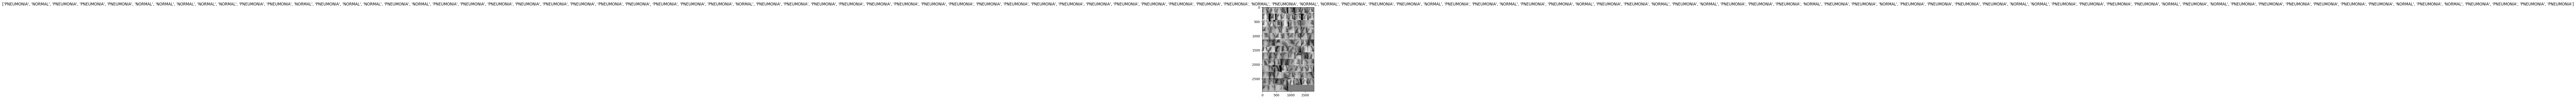

In [20]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [21]:
y_true = []
for inputs, labels in image_datasets['test']:
    y_true.append(labels)
y_true = np.array(y_true)
y_true = torch.from_numpy(y_true)
#print(all_test_images.shape) 

In [3]:
y_true_val = []
for inputs, labels in image_datasets['val']:
    y_true_val.append(labels)
y_true_val = np.array(y_true_val)
y_true_val = torch.from_numpy(y_true_val)
#print(all_test_images.shape) 

In [22]:
image_datasets['test']

Dataset ImageFolder
    Number of datapoints: 624
    Root location: /kaggle/input/chest-xray-pneumonia/chest_xray/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
           )

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phs in phase[:2]:
            if phs == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phs]:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)
#                 inputs, labels = inputs.cuda(), labels.cuda()
#                 inputs = inputs.to(torch.device('cuda'))
#                 labels = labels.to(torch.device('cuda'))
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phs == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phs == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            #if phs == 'Train':
                #scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phs]
            epoch_acc = running_corrects.double() / dataset_sizes[phs]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phs, epoch_loss, epoch_acc))

            # deep copy the model
            if phs == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model



In [11]:
def make_prediction(model):
    test_images = []
    for inputs, _ in image_datasets['test']:
        test_images.append(inputs)
    test_images = np.array(test_images)
    all_test_images = torch.from_numpy(test_images)
    outputs = model(all_test_images)    
    _, predictions =  torch.max(outputs,1)
    #return predictions.cpu().detach().numpy() 
    return predictions

In [59]:
def model_performance(y_pred,y_true=y_true,target_names=class_names):
    #print(classification_report(y_true, y_pred, target_names=target_names))
    print(f'score : {accuracy_score(y_true, y_pred):.5f}')
    
    

# CNN 

In [26]:
conv1 = nn.Conv2d(3,6,5)
pool = nn.MaxPool2d(2,2) 
conv2 = nn.Conv2d(6,6,5,2)
fc1 = nn.Linear(150,100)
fc2 = nn.Linear(100,23)

In [32]:
x = conv1(all_test_images)
print(x.shape)
x = pool(x)
print(x.shape)
x = conv2(x)
print(x.shape)
x = pool(x)
print(x.shape)
x = conv2(x)
print(x.shape)
x = pool(x)
print(x.shape)





torch.Size([624, 6, 220, 220])
torch.Size([624, 6, 110, 110])
torch.Size([624, 6, 53, 53])
torch.Size([624, 6, 26, 26])
torch.Size([624, 6, 11, 11])
torch.Size([624, 6, 5, 5])


In [31]:
6*26*26

4056

In [29]:
test_images = []
for inputs, _ in image_datasets['test']:
    test_images.append(inputs)
test_images = np.array(test_images)
all_test_images = torch.from_numpy(test_images)  

In [ ]:
conv1 = nn.Conv2d(3,6,5)
pool = nn.MaxPool2d(2,2) 
conv2 = nn.Conv2d(6,6,5,2)

In [33]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2) 
        self.conv2 = nn.Conv2d(6,6,5,2)
        self.conv3 = nn.Conv2d(6,6,5,2)
        self.fc1 = nn.Linear(150,100)
        self.fc2 = nn.Linear(100,2)
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1,150)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x 
        

        
        

In [56]:
model_conv = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.Adam(model_conv.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_conv = train_model(model_conv, criterion, optimizer_conv,exp_lr_scheduler,num_epochs=1)

Epoch 1/1
----------
train Loss: 0.5180 Acc: 0.7711
val Loss: 0.8560 Acc: 0.5625

Training complete in 2m 5s
Best val Acc: 0.562500


In [31]:
y_pred_conv=make_prediction(model_conv)
model_performance(y_pred_conv,y_true)

score : 0.79647


# Fine tuning Alexnet 

In [63]:
model_alexnet = models.alexnet(pretrained=True)
for param in model_alexnet.parameters():
    param.requires_grad = False
num_ftrs = model_alexnet.classifier[6].in_features
model_alexnet.classifier[6] = nn.Linear(num_ftrs, len(class_names))
#num_ftrs = model_alexnet.fc.in_features
#model_alexnet.fc = nn.Linear(num_ftrs,len(class_names)) # adding classification layer on top on resnet18
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_alexnet.parameters(), lr=0.001)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model_alexnet = train_model(model_alexnet, criterion, optimizer, step_lr_scheduler, num_epochs=20)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20
----------
train Loss: 0.3526 Acc: 0.8466
val Loss: 0.5307 Acc: 0.7500

Epoch 2/20
----------
train Loss: 0.2786 Acc: 0.8813
val Loss: 0.7936 Acc: 0.6875

Epoch 3/20
----------
train Loss: 0.2716 Acc: 0.8834
val Loss: 0.6699 Acc: 0.6875

Epoch 4/20
----------
train Loss: 0.2607 Acc: 0.8903
val Loss: 0.8567 Acc: 0.6250

Epoch 5/20
----------
train Loss: 0.2728 Acc: 0.8848
val Loss: 0.8888 Acc: 0.6250

Epoch 6/20
----------
train Loss: 0.2678 Acc: 0.8871
val Loss: 0.3648 Acc: 0.8750

Epoch 7/20
----------
train Loss: 0.2693 Acc: 0.8842
val Loss: 1.0070 Acc: 0.6250

Epoch 8/20
----------
train Loss: 0.2553 Acc: 0.8934
val Loss: 0.7409 Acc: 0.6875

Epoch 9/20
----------
train Loss: 0.2643 Acc: 0.8871
val Loss: 0.7773 Acc: 0.6250

Epoch 10/20
----------
train Loss: 0.2738 Acc: 0.8831
val Loss: 1.1677 Acc: 0.6250

Epoch 11/20
----------
train Loss: 0.2695 Acc: 0.8882
val Loss: 0.9815 Acc: 0.6875

Epoch 12/20
----------
train Loss: 0.2568 Acc: 0.8947
val Loss: 0.9109 Acc: 0.6875

E

In [32]:
y_pred_alex=make_prediction(model_alexnet)
model_performance(y_pred_alex,y_true)

score : 0.89904


# Finetuning Vgg 

In [69]:
model_vgg = models.vgg11(weights=models.VGG11_Weights.IMAGENET1K_V1)
# Modify the classifier
for param in model_vgg.parameters():
    param.requires_grad = False
num_ftrs = model_vgg.classifier[6].in_features
model_vgg.classifier[6] = nn.Linear(num_ftrs, len(class_names))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vgg.parameters(), lr=0.001)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.001)
model_vgg = train_model(model_vgg, criterion, optimizer, step_lr_scheduler, num_epochs=10)

Epoch 1/2
----------
train Loss: 0.4075 Acc: 0.8230
val Loss: 0.5214 Acc: 0.6875

Epoch 2/2
----------
train Loss: 0.3036 Acc: 0.8781
val Loss: 0.4770 Acc: 0.6875

Training complete in 26m 52s
Best val Acc: 0.687500


In [33]:
y_pred_vgg=make_prediction(model_vgg)
model_performance(y_pred_vgg)

score : 0.81250


# Fine tuning Resnet 

In [16]:

model_resnet = torchvision.models.resnet18(pretrained=True)
for param in model_resnet.parameters():
    param.requires_grad = False
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs,len(class_names))
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.Adam(model_resnet.fc.parameters(), lr=0.1)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_resnet = train_model(model_resnet, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=10)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
----------
train Loss: 4.0607 Acc: 0.7985
val Loss: 6.6396 Acc: 0.5625

Epoch 2/10
----------
train Loss: 0.7132 Acc: 0.8831
val Loss: 0.6341 Acc: 0.8750

Epoch 3/10
----------
train Loss: 0.8032 Acc: 0.8604
val Loss: 1.3618 Acc: 0.8125

Epoch 4/10
----------
train Loss: 1.7240 Acc: 0.8470
val Loss: 2.9779 Acc: 0.6875

Epoch 5/10
----------
train Loss: 0.8334 Acc: 0.8750
val Loss: 2.7415 Acc: 0.5625

Epoch 6/10
----------
train Loss: 1.1410 Acc: 0.8551
val Loss: 0.8269 Acc: 0.8750

Epoch 7/10
----------
train Loss: 0.7656 Acc: 0.8706
val Loss: 5.8892 Acc: 0.5625

Epoch 8/10
----------
train Loss: 1.3729 Acc: 0.8501
val Loss: 15.1659 Acc: 0.5000

Epoch 9/10
----------
train Loss: 0.9048 Acc: 0.8875
val Loss: 0.7955 Acc: 0.6875

Epoch 10/10
----------
train Loss: 0.8711 Acc: 0.8767
val Loss: 4.9660 Acc: 0.5625

Training complete in 44m 3s
Best val Acc: 0.875000


In [40]:
y_pred_resnet=make_prediction(model_resnet)
model_performance(y_pred_resnet)

score : 0.89423


# classification Report 

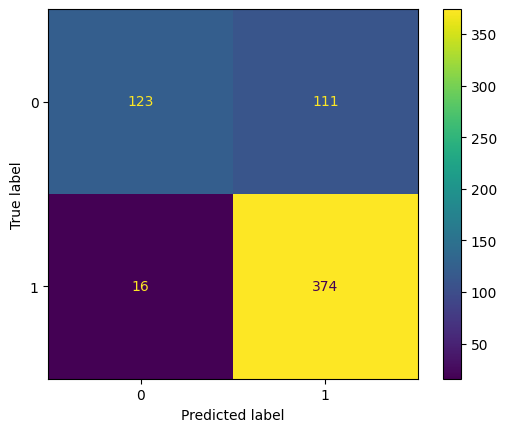

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true,y_pred_conv,)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

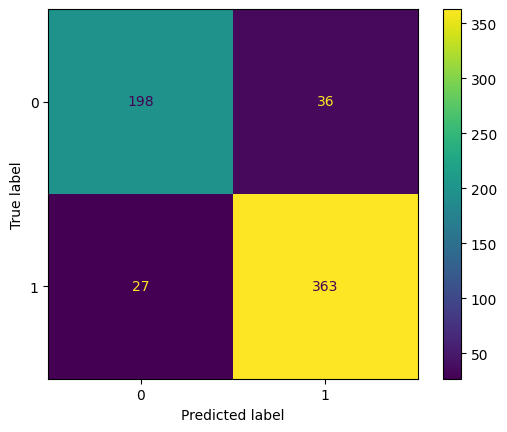

In [36]:
cm = confusion_matrix(y_true,y_pred_alex)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

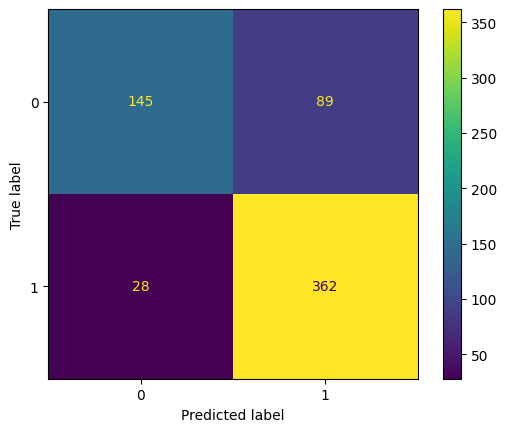

In [37]:
cm = confusion_matrix(y_true,y_pred_vgg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

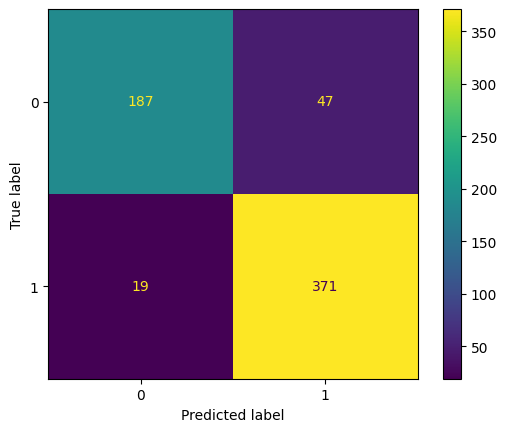

In [41]:
cm = confusion_matrix(y_true,y_pred_resnet)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Save model 

In [18]:
resnet = torch.save(model_resnet.state_dict(),"/kaggle/working/model_resnet.pth")

In [19]:
model = torch.load('/kaggle/working/model_resnet.pth')

In [24]:
import pickle

In [25]:
pickle.dump(model_resnet, open('model.pkl','wb'))


In [26]:
model = pickle.load(open('model.pkl','rb'))


In [27]:
make_prediction(model)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [42]:
all_test_images.shape

torch.Size([624, 3, 224, 224])